In [82]:
from utils import *
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

Simple implementation of Model Predictive Control with a Periodic Observer ($\Pi$-MPC) on a pendulum.

The nominal model for the system is a linearization with wrong model parameters.

## Real System Dynamics (Pendulum)

In [83]:
# Dimensions
nx = 2 # State (theta, dtheta)
nu = 1 # Input (tau)
ny = 1 # Output (theta)
nr = 1 # Controlled variable (theta)
nd = ny # Disturbance
dims_dic = {'nx':nx,'nu':nu,'ny':ny,'nr':nr,'nd':nd}

# Dimension checks
if nd > ny:
    raise ValueError('nd > ny')
if nr > nu:
    raise ValueError('nr > nu')

# Time discretization
Delta = 0.1

# Model parameters
params_dic = {'m':1,'g':9.81,'l':1,'b':0.2} # True parameters
est_params_dic = {'m':1.2,'g': 9.6, 'l':0.9,'b' :0.2} # Wrong parameters (Model mismatch)

# Instantiate pendulum simulator class
simulator = PendulumSimulator(params_dic, Delta)

# Linearize and discretize nominal model
x_lin = np.array([np.pi, 0]) # Linearization point
u_lin = np.array([0])
A, B = linearize_dyn(x_lin, u_lin, est_params_dic, Delta)
statespace = control.c2d(control.StateSpace(A,B,np.eye(nx),np.zeros((nx,nu))),Delta)
A, B = statespace.A, statespace.B
C = np.array([[1,0]])
H = np.array([[1]])

nominal_dyn_dic = {'A':A,'B':B,'C':C,'H':H,'Delta':Delta}

## $\Pi$-MPC (Offline Design)

### Disturbance Model

In [84]:
# Set trajectory reference period 
period = 2 # period length in seconds
Nperiod = int(period/Delta)

# Disturbance model design
# \bar{B} = Bd, and \bar{C} = Cd
Bd = B # Modeling an input disturbance
Cd = np.zeros((ny,nd))
A_aug, B_aug, C_aug = periodic_augmented(A, B, C, Bd, Cd, Nperiod)

# Observability check - condition (6) in the paper
Sd = create_Sd(nd, Nperiod)
Ssel = create_Ssel(nd, Nperiod)
Sd_spectrum = np.linalg.eigvals(Sd)
for lam in Sd_spectrum:
    svds = sp.linalg.svdvals(np.bmat([  [A - lam*np.eye(nx), Bd],
                                        [C, Cd]]))
    rank = sum(svds > 1e-8)
    if rank < nx + nd:
        print("*Warning: system not observable!")

### Observer Design

In [85]:
# Design observer
Q_kalman = block_diag(np.eye(nx), 100*np.eye(nd*Nperiod)) 
# Increased weight on the disturbance for faster convergence
R_kalman = np.eye(ny)
K, S, E = control.dlqr(A_aug.T, C_aug.T, Q_kalman, R_kalman)
L= -K.T # Observer gain

print('Eigenvalues of A_aug + L @ C_aug:')
print(np.round(np.abs(np.linalg.eigvals(A_aug + L @ C_aug)), 6))
if any (np.abs(np.linalg.eigvals(A_aug + L @ C_aug)) > 1):
    print('*Warning: Observer not stable!')

Eigenvalues of A_aug + L @ C_aug:
[0.999983 0.999192 0.999192 0.998297 0.998297 0.997202 0.997202 0.995739
 0.995739 0.993619 0.993619 0.990288 0.990288 0.984564 0.984564 0.973513
 0.973513 0.343937 0.948244 0.948244 0.880618 0.880618]


### Reference Trajectory and MPC Parameters

In [86]:
# Define reference trajectory
def ref_z(t):
    # Sine wave
    return np.sin((2*np.pi/period)*t) + np.pi

# MPC parameters
Nsim = 501 # Simulation length
Nhor = 10 # Horizon length

# Weighting matrices for controller.
Qz = np.diag([1000])
R = np.diag([0.001])

# Initial state and Input
x0 = np.array([0, 0])
u0 = np.array([0])

# Bounds
u_max = 50
MPC_dic = {'Nsim':Nsim,'Nhor':Nhor,'Q':Qz,'R':R,'x0':x0,'u0':u0,'ref_z':ref_z,'u_max':u_max}

## $\Pi$-MPC (Online operation)
This uses the implementation described in Sec. VB

In [87]:
# Construct the cvxpy problem
cvx_usp = cp.Parameter((Nhor * nu))
cvx_usp.value = np.zeros((Nhor * nu))
cvx_zsp = cp.Parameter(((Nhor+1) * nr))
cvx_zsp.value = np.zeros(((Nhor+1) * nr))
cvx_x0 = cp.Parameter(nx)
cvx_x0.value = x0
cvx_d = cp.Parameter(((Nhor+1) * nd))
cvx_d.value = np.zeros(((Nhor+1) * nd))
cvx_u = cp.Variable((Nhor * nu))
cvx_x = cp.Variable(((Nhor+1) * nx))

# Define cost function and constraints
Qfull = block_diag(*[Qz]*(Nhor+1))
Rfull = block_diag(*[R]*(Nhor))
HCfull = cp_block_diag(H@C, Nhor+1)
Cdfull = cp_block_diag(H@Cd, Nhor+1)
obj = cp.Minimize(cp.quad_form(HCfull @ cvx_x + Cdfull @ cvx_d - cvx_zsp, Qfull) + cp.quad_form(cvx_u - cvx_usp, Rfull))
# Constraints
Afull = cp_block_diag(A, Nhor)
Bfull = cp_block_diag(B, Nhor)
Bdfull = cp_block_diag(Bd, Nhor)
constr = [cvx_x[0:nx] == cvx_x0] # Initial condition
constr += [cvx_x[nx:] == Afull @ cvx_x[:-nx] + Bfull @ cvx_u + Bdfull @ cvx_d[:-nd]] # Dynamics
constr += [cvx_u >= -u_max, cvx_u <= u_max] # Input constraints
# Build problem
prob = cp.Problem(obj, constr)

# Functions to generate reference trajectory for the next Nhor steps
def set_zsp(k):
    for i in range(Nhor+1):
        t = (k + i)*Delta
        cvx_zsp.value[i*nr:(i+1)*nr] = ref_z(t)
# This function is used to regularize the input to be N-periodic
def set_usp(k):
    wait_per = 1 # Wait this many periods before periodically regularizing the input
    # Until then, regularize the input to zero (can help avoid chatter)
    for i in range(Nhor):
        if k+i-wait_per*Nperiod >= 0 and k+i-Nperiod < Nsim:
            cvx_usp.value[i*nu:(i+1)*nu] = u[k+i-Nperiod,:]

# Initialize
x = np.zeros((Nsim, nx))
x[0,:] = x0
u = np.zeros((Nsim, nu))
u[0,:] = u0
y = np.zeros((Nsim, ny))
y[0,:] = C @ x0
z = np.zeros((Nsim, nr))
z[0,:] = H @ y[0,:]

ref = np.zeros((Nsim, nr))
uref = np.zeros((Nsim, nu))

# Observer variables
xhat = np.zeros((Nsim, nx))
xhat[0,:] = x0
dhat = np.zeros((Nsim, nd*Nperiod))
dhat[0,:] = np.zeros(nd*Nperiod)
innov = np.zeros((Nsim, nx+nd*Nperiod))

x_planned = np.zeros((Nsim, nx))

# Solve the problem
for k in range(Nsim-1):
    # Set parameters
    cvx_x0.value = xhat[k,:]
    for i in range(Nhor+1):
        cvx_d.value[i*nd:(i+1)*nd] = dhat[k,(i%Nperiod)*nd:((i%Nperiod)+1)*nd]
    # Set reference
    set_zsp(k)
    ref[k,:] = cvx_zsp.value[:nr]
    set_usp(k)
    uref[k,:] = cvx_usp.value[:nu]

    # Solve the problem, Eq. (13)
    try:
        prob.solve(solver=cp.OSQP, warm_start=True)
    except:
        print("***Error during optimization!")
        break

    # Store the solution
    if k < Nsim-Nhor and k % Nhor == 0:
        for i in range(Nhor):
            x_planned[k+i, :] = cvx_x.value[(i)*nx:(i+1)*nx]
    u[k,:] = cvx_u.value[:nu]

    # Apply first optimal input (Simulate with true nonlinear model)
    try:
        x[k+1,:] = simulator.sim(x[k,:], u[k,:])
    except:
        print("***Error during simulation!")
        break
    y[k+1,:] = C @ x[k+1,:]
    z[k+1,:] = H @ y[k+1,:]

    # Use measurement to update the state and disturbance estimates using Eq. (7)
    innov[k,:] = L @ ( C @ xhat[k,:] + Cd @ dhat[k,:nd] - y[k,:] )
    xhat[k+1,:] = A @ xhat[k,:] + B @ u[k,:] + Bd @ dhat[k,:nd] + innov[k,:nx]
    dhat[k+1,:] = Sd @ dhat[k,:] + innov[k,nx:]

In [88]:
# Simulation w/ baseline MPC (for comparison)
x_base, u_base, y_base, z_base, xhat_base, ref_base, x_planned_base, innov_base = MPC(simulator, dims_dic, MPC_dic, nominal_dyn_dic)

MPC: Done


### Plotting

Text(0.5, 1.0, 'RMSE in each period')

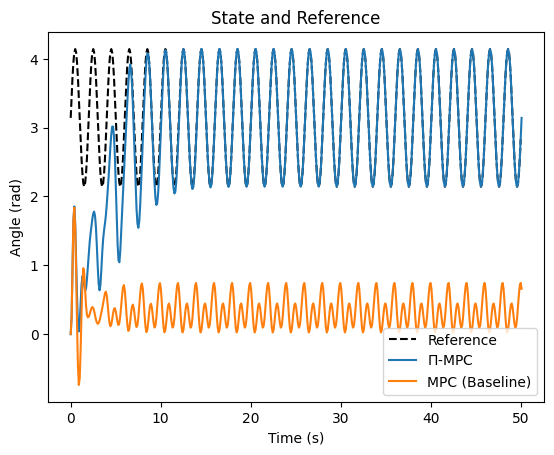

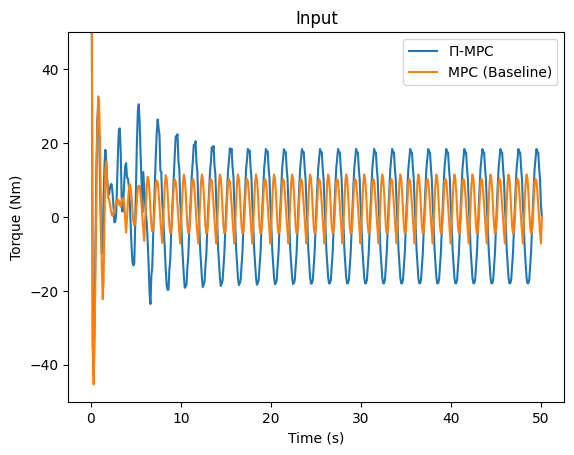

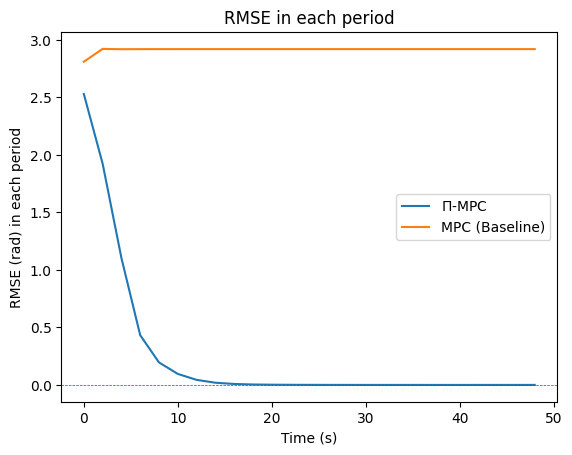

In [89]:
# Plot results
# Plot state and reference
plt.figure()
plt.plot(np.linspace(0, Nsim*Delta, Nsim)[:-1], ref[:-1,0], 'k--', label='Reference')
plt.plot(np.linspace(0, Nsim*Delta, Nsim), x[:,0], label=r'$\Pi$-MPC')
plt.plot(np.linspace(0, Nsim*Delta, Nsim), x_base[:,0], label='MPC (Baseline)')
plt.title('State and Reference')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

# Plot input
plt.figure()
plt.plot(np.linspace(0, Nsim*Delta, Nsim), u, label=r'$\Pi$-MPC')
plt.plot(np.linspace(0, Nsim*Delta, Nsim), u_base, label='MPC (Baseline)')
plt.title('Input')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.ylim([-u_max, u_max])
plt.legend()

# Collect RMSE for each period.
total_time = Nsim*Delta
total_periods = int(total_time//period)
RMSEs_PiMPC = np.zeros((total_periods, 1))
RMSEs_base = np.zeros((total_periods, 1))
for i in range(total_periods):
    start = int(i*period//Delta)
    end = int((i+1)*period//Delta)
    RMSEs_PiMPC[i] = np.sqrt(np.mean((x[start:end,0] - ref[start:end,0])**2))
    RMSEs_base[i] = np.sqrt(np.mean((x_base[start:end,0] - ref_base[start:end,0])**2))
# Plot RMSEs
plt.figure()
plt.plot(np.arange(total_periods)*period, RMSEs_PiMPC, label=r"$\Pi$-MPC")
plt.plot(np.arange(total_periods)*period, RMSEs_base, label="MPC (Baseline)")
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.5)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("RMSE (rad) in each period")
plt.title("RMSE in each period")